# MaldiAMRKit - Quick Start

This notebook covers the basics of loading, preprocessing, and binning MALDI-TOF spectra.

If you haven't installed the package yet, run:
```bash
pip install maldiamrkit
```

## Import MaldiAMRKit

In [1]:
from maldiamrkit import (
    MaldiSpectrum,
    MaldiSet,
    PreprocessingSettings,
    estimate_snr,
    SpectrumQuality,
)

## Preprocessing Settings

View the default preprocessing parameters.

In [2]:
default_cfg = PreprocessingSettings()
default_cfg.as_dict()

{'trim_from': 2000,
 'trim_to': 20000,
 'savgol_window': 20,
 'savgol_poly': 2,
 'baseline_half_window': 40}

## Load and Preprocess a Single Spectrum

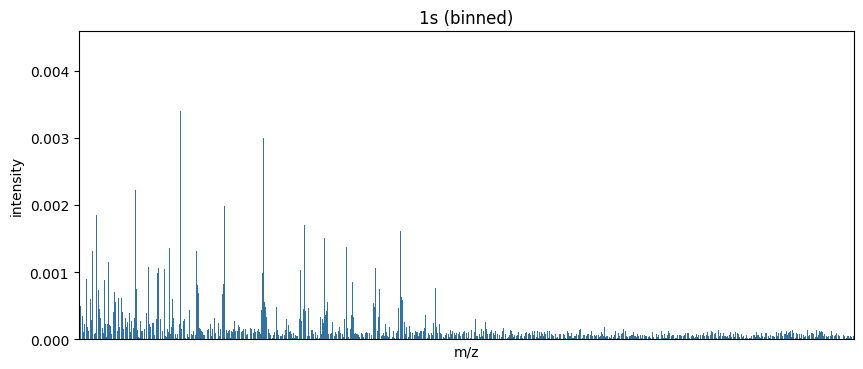

In [3]:
# Load, preprocess (smoothing, baseline removal, normalization), and bin
spec = MaldiSpectrum("../data/1s.txt").preprocess()
spec.bin(3)  # bin width 3 Da

# Plot the binned spectrum
_ = spec.plot(binned=True)

### Verbose Mode

Enable verbose mode to see processing messages.

In [4]:
spec = MaldiSpectrum("../data/1s.txt", verbose=True).preprocess()
spec.bin(3).binned

INFO: Preprocessed spectrum 1s
INFO: Binned spectrum 1s (method=uniform, w=3)


,mass,intensity
0,2000,0.000039
1,2003,0.000041
2,2006,0.000083
3,2009,0.000123
4,2012,0.000109
...,...,...
5995,19985,0.000087
5996,19988,0.000054
5997,19991,0.000048
5998,19994,0.000050


### Plot Without Binning

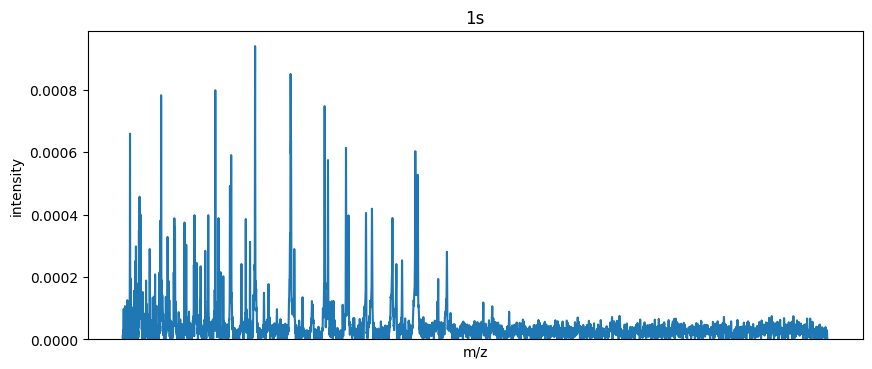

In [5]:
spec = MaldiSpectrum("../data/1s.txt").preprocess()
_ = spec.plot(binned=False)

## Quality Assessment

### Signal-to-Noise Ratio (SNR)

Use `estimate_snr()` to assess spectrum quality. Higher SNR indicates better signal quality.

In [6]:
spec = MaldiSpectrum("../data/1s.txt").preprocess()
snr = estimate_snr(spec.preprocessed)
print(f"Signal-to-Noise Ratio: {snr:.1f}")

Signal-to-Noise Ratio: 67.2


### Comprehensive Quality Report

Use `SpectrumQuality` for a comprehensive quality assessment.

In [7]:
qc = SpectrumQuality()
report = qc.assess(spec.preprocessed)
print(f"SNR: {report.snr:.1f}")
print(f"Total Ion Count: {report.total_ion_count:.2e}")
print(f"Peak Count: {report.peak_count}")
print(f"Baseline Fraction: {report.baseline_fraction:.2%}")
print(f"Dynamic Range: {report.dynamic_range:.2f}")

SNR: 67.2
Total Ion Count: 1.00e+00
Peak Count: 74
Baseline Fraction: 46.26%
Dynamic Range: 1.46


## Binning Methods

MaldiAMRKit supports multiple binning strategies: uniform (default), logarithmic, adaptive, and custom.

In [8]:
import numpy as np

spec = MaldiSpectrum("../data/1s.txt").preprocess()

# Uniform binning (default)
spec.bin(bin_width=3)
print(f"Uniform: {len(spec.binned)} bins")
print(spec.bin_metadata.head())

Uniform: 6000 bins
   bin_index  bin_start  bin_end  bin_width
0          0       2000     2003          3
1          1       2003     2006          3
2          2       2006     2009          3
3          3       2009     2012          3
4          4       2012     2015          3


In [9]:
# Logarithmic binning (bin width scales with m/z)
spec.bin(bin_width=3, method="logarithmic")
print(f"Logarithmic: {len(spec.binned)} bins")
print(f"Width at start: {spec.bin_metadata.iloc[0]['bin_width']:.2f} Da")
print(f"Width at end: {spec.bin_metadata.iloc[-1]['bin_width']:.2f} Da")

Logarithmic: 1537 bins
Width at start: 3.00 Da
Width at end: 29.99 Da


In [10]:
# Adaptive binning (smaller bins in peak-dense regions)
spec.bin(method="adaptive", adaptive_min_width=1.0, adaptive_max_width=10.0)
print(f"Adaptive: {len(spec.binned)} bins")
print(f"Min width: {spec.bin_metadata['bin_width'].min():.2f} Da")
print(f"Max width: {spec.bin_metadata['bin_width'].max():.2f} Da")

Adaptive: 4542 bins
Min width: 1.00 Da
Max width: 7.89 Da


In [11]:
# Custom binning (user-defined edges)
custom_edges = np.linspace(2000, 20000, 50)  # 49 bins
spec.bin(method="custom", custom_edges=custom_edges)
print(f"Custom: {len(spec.binned)} bins")
print(spec.bin_metadata.head())

Custom: 49 bins
   bin_index    bin_start      bin_end   bin_width
0          0  2000.000000  2367.346939  367.346939
1          1  2367.346939  2734.693878  367.346939
2          2  2734.693878  3102.040816  367.346939
3          3  3102.040816  3469.387755  367.346939
4          4  3469.387755  3836.734694  367.346939


## Build a Dataset from Multiple Spectra

Use `MaldiSet` to load and process multiple spectra with metadata.

In [12]:
data = MaldiSet.from_directory(
    "../data/",
    "../data/metadata/metadata.csv",
    aggregate_by=dict(antibiotics="Drug"),
)
X, y = data.X, data.y

print(f"Features shape: {X.shape}")
print(f"Labels shape: {y.shape}")

Features shape: (29, 6000)
Labels shape: (29, 1)


In [13]:
y.head()

,Drug
10s,S
11s,R
12s,R
13s,S
14s,S


### Pseudogel Visualization

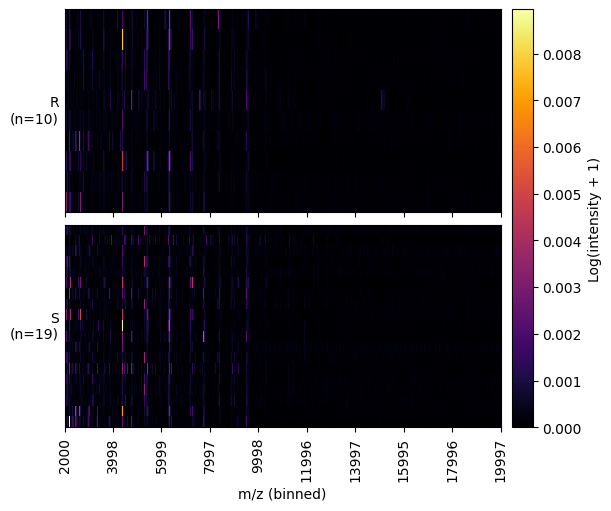

In [14]:
_ = data.plot_pseudogel()

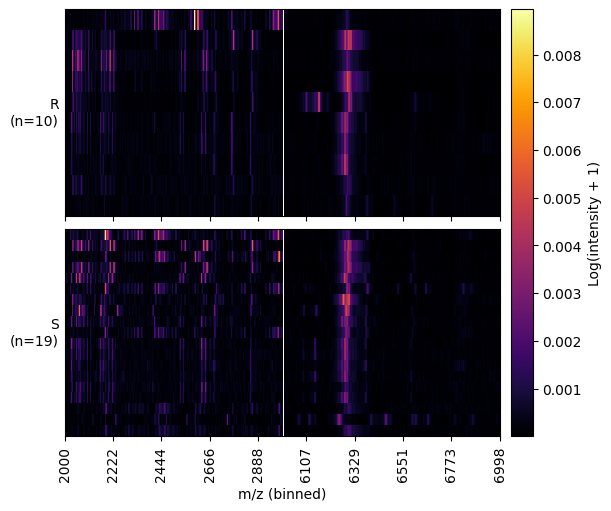

In [15]:
_ = data.plot_pseudogel(regions=[(2000, 3000), (6000, 7000)])

### Prepare Labels for Classification

In [16]:
# Map Resistant (and intermediate) strains to 1, susceptible strains to 0
y_binary = y["Drug"].map({"S": 0, "I": 1, "R": 1})
y_binary.head()

10s    0
11s    1
12s    1
13s    0
14s    0
Name: Drug, dtype: int64